# Importing Libraries

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [36]:
# Load preprocessed data
df = pd.read_csv("/content/drive/MyDrive/NOTBOOKS/preprocessed_data.csv")

In [37]:
# Check the data structure
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90083 entries, 0 to 90082
Data columns (total 31 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Month                                               90083 non-null  object 
 1   Age                                                 90083 non-null  float64
 2   Occupation                                          90083 non-null  object 
 3   Annual_Income                                       90083 non-null  float64
 4   Monthly_Inhand_Salary                               90083 non-null  float64
 5   Num_Bank_Accounts                                   90083 non-null  int64  
 6   Num_Credit_Card                                     90083 non-null  int64  
 7   Interest_Rate                                       90083 non-null  int64  
 8   Num_of_Loan                                         90083 non-null  float64


# Data Preprocessing

In [38]:
# Check for missing values
df.isnull().sum()

,0
Month,0
Age,0
Occupation,0
Annual_Income,0
Monthly_Inhand_Salary,0
Num_Bank_Accounts,0
Num_Credit_Card,0
Interest_Rate,0
Num_of_Loan,0
Type_of_Loan,0


In [39]:
# Encode target variable 'Credit_Score'
le = LabelEncoder()
df['Credit_Score'] = le.fit_transform(df['Credit_Score'])

# Drop Unnecessary Columns
df.drop(columns=['Month'], axis=1, inplace=True)

# Verify encoding
#df.head()


In [40]:
print(df['Occupation'].nunique())
print(df['Type_of_Loan'].nunique())


16
6231


In [41]:
# Statistical Tests to determine if the Occupation and Type_of_Loan columns are relevant for predicting the target (Credit_Score)
from scipy.stats import chi2_contingency

# Chi-square test for 'Occupation' and 'Credit_Score'
contingency_occupation = pd.crosstab(df['Occupation'], df['Credit_Score'])
chi2, p, _, _ = chi2_contingency(contingency_occupation)
print(f"Chi-square test for 'Occupation': p-value = {p}")

# Chi-square test for 'Type_of_Loan' and 'Credit_Score'
contingency_loan_type = pd.crosstab(df['Type_of_Loan'], df['Credit_Score'])
chi2, p, _, _ = chi2_contingency(contingency_loan_type)
print(f"Chi-square test for 'Type_of_Loan': p-value = {p}")


Chi-square test for 'Occupation': p-value = 1.7671780343329184e-18
Chi-square test for 'Type_of_Loan': p-value = 0.0


- Since both p-values are extremely small, so both features are highly relevant to the prediction of the credit score.

In [42]:
df['Occupation'].unique()

array(['Scientist', 'Teacher', '_______', 'Entrepreneur', 'Developer',
       'Lawyer', 'Media_Manager', 'Doctor', 'Journalist', 'Engineer',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

In [43]:
occupation_mapping = {

     'Scientist': 'Technology & Engineering',
    'Developer': 'Technology & Engineering',
    'Engineer': 'Technology & Engineering',
    'Architect': 'Technology & Engineering',
    'Mechanic': 'Technology & Engineering' ,

    'Doctor': 'Healthcare',

    'Teacher': 'Creative & Media',
    'Media_Manager': 'Creative & Media',
    'Musician': 'Creative & Media',
    'Writer': 'Creative & Media',
    'Journalist': 'Creative & Media',

    'Lawyer': 'Legal/Managerial',
    'Manager': 'Legal/Managerial',
    'Accountant': 'Legal/Managerial',
    'Entrepreneur': 'Legal/Managerial',
}

# Apply the mapping to reduce the number of unique occupations
df['Occupation_grouped'] = df['Occupation'].map(occupation_mapping)

# Fill missing values with 'Other'
df['Occupation_grouped'] = df['Occupation_grouped'].fillna('Other')

# Check the unique values after mapping
print(df['Occupation_grouped'].unique())

# drop the original 'Occupation'
df.drop('Occupation', axis=1, inplace=True)

# One-Hot Encoding using  get_dummies
df = pd.get_dummies(df, columns=['Occupation_grouped'], drop_first=True)



['Technology & Engineering' 'Creative & Media' 'Other' 'Legal/Managerial'
 'Healthcare']


In [44]:
# Target Encoding for 'Type_of_Loan'
mean_target = df.groupby('Type_of_Loan')['Credit_Score'].mean()
df['Type_of_Loan_encoded'] = df['Type_of_Loan'].map(mean_target)

#  drop the original 'Type_of_Loan'
df.drop('Type_of_Loan', axis=1, inplace=True)


In [45]:
df.head(5)

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,Occupation_grouped_Healthcare,Occupation_grouped_Legal/Managerial,Occupation_grouped_Other,Occupation_grouped_Technology & Engineering,Type_of_Loan_encoded
0,23.0,9.858235,7.509797,3,4,3,4.0,3,7.0,11.27,...,False,True,False,False,False,False,False,False,True,0.285714
1,23.0,9.858235,8.037461,3,4,3,4.0,-1,5.6,11.27,...,False,False,True,False,False,False,False,False,True,0.285714
2,23.0,9.858235,8.037461,3,4,3,4.0,5,4.0,6.27,...,False,False,False,False,True,False,False,False,True,0.285714
3,23.0,9.858235,7.509797,3,4,3,4.0,6,5.6,11.27,...,True,False,False,False,False,False,False,False,True,0.285714
4,23.0,9.858235,8.037461,3,4,3,4.0,8,4.0,9.27,...,False,False,False,False,False,False,False,False,True,0.285714


####- the dataset is imbalanced, it's essential to balance the data to ensure that the model doesn't get biased towards the majority class. For this purpose, the Synthetic Minority Over-sampling Technique (SMOTE) is used, which generates synthetic samples for the minority class.

# Feature Engineering and Selection

Create new features, such as:
- Debt_to_Income_Ratio = Outstanding_Debt / Annual_Income
- Savings_to_Income_Ratio = Monthly_Balance / Monthly_Inhand_Salary
- Convert Credit_History_Age into numeric years.
- Convert 'Changed_Credit_Limit' to numeric

In [46]:
# Create new features
df['Debt_to_Income_Ratio'] = df['Outstanding_Debt'] / (df['Annual_Income'] + 1)
df['Savings_to_Income_Ratio'] = df['Monthly_Balance'] / (df['Monthly_Inhand_Salary'] + 1)

# Convert 'Credit_History_Age' to numeric
if df['Credit_History_Age'].dtype == object:
    df['Credit_History_Age'] = df['Credit_History_Age'].str.extract(r'(\d+)').astype(float)

# Convert 'Changed_Credit_Limit' to numeric
df['Changed_Credit_Limit'] = pd.to_numeric(df['Changed_Credit_Limit'], errors='coerce')

# Impute missing values in 'Changed_Credit_Limit' using the median
from sklearn.impute import SimpleImputer

# Initialize the imputer
imputer = SimpleImputer(strategy='median')

# Apply the imputer to the 'Changed_Credit_Limit' column
df['Changed_Credit_Limit'] = imputer.fit_transform(df[['Changed_Credit_Limit']])

# Verify that there are no more NaN values in 'Changed_Credit_Limit'
print(df['Changed_Credit_Limit'].isna().sum())



0


In [47]:
# Select numerical columns for scaling
numerical_cols = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
                  'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                  'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                  'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                  'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly',
                  'Monthly_Balance', 'Type_of_Loan_encoded', 'Debt_to_Income_Ratio',
                  'Savings_to_Income_Ratio']

# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Check the scaled data
print(df[numerical_cols].head())


        Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0 -0.933281      -0.864032              -0.682818          -0.121461   
1 -0.933281      -0.864032               0.080267          -0.121461   
2 -0.933281      -0.864032               0.080267          -0.121461   
3 -0.933281      -0.864032              -0.682818          -0.121461   
4 -0.933281      -0.864032               0.080267          -0.121461   

   Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  \
0        -0.143933        -0.1497     0.018539            -1.237303   
1        -0.143933        -0.1497     0.018539            -1.504972   
2        -0.143933        -0.1497     0.018539            -1.103468   
3        -0.143933        -0.1497     0.018539            -1.036551   
4        -0.143933        -0.1497     0.018539            -0.902716   

   Num_of_Delayed_Payment  Changed_Credit_Limit  ...  Outstanding_Debt  \
0               -0.112473              0.111582  ...         -0.55

In [48]:
# Define features and target
X = df.drop(columns=['Credit_Score'])  # Drop the target variable 'Credit_Score'
y = df['Credit_Score']  # The target variable

# Compute mutual information for classification problems
mutual_info_scores = mutual_info_classif(X, y)

# Create a DataFrame with features and their corresponding mutual information scores
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mutual_info_scores})

#  Sort the features based on their mutual information scores in descending order
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)

# Get top 10 features based on mutual information
top_mi_features = mi_df.head(10)['Feature']

# Train Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

#  Get feature importances
importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Get top 10 features based on feature importance
top_rf_features = importance_df.head(10)['Feature']

# Combine both top features, removing duplicates
selected_features = pd.concat([top_mi_features, top_rf_features]).drop_duplicates()

#  Create a new dataframe with the selected features
X_selected = X[selected_features]

# Print the selected features
print(f"Selected features based on mutual information and feature importance:\n{selected_features}")


Selected features based on mutual information and feature importance:
11            Outstanding_Debt
32        Debt_to_Income_Ratio
1                Annual_Income
15         Total_EMI_per_month
2        Monthly_Inhand_Salary
31        Type_of_Loan_encoded
5                Interest_Rate
7          Delay_from_due_date
10        Num_Credit_Inquiries
14       Payment_of_Min_Amount
13          Credit_History_Age
9         Changed_Credit_Limit
16     Amount_invested_monthly
12    Credit_Utilization_Ratio
Name: Feature, dtype: object


#### All of the selected features are logical and meaningful for evaluating credit risk. They cover key financial aspects like income, debt, credit utilization, loan types, payment behavior, and credit history—all of which are important factors influencing credit scores.


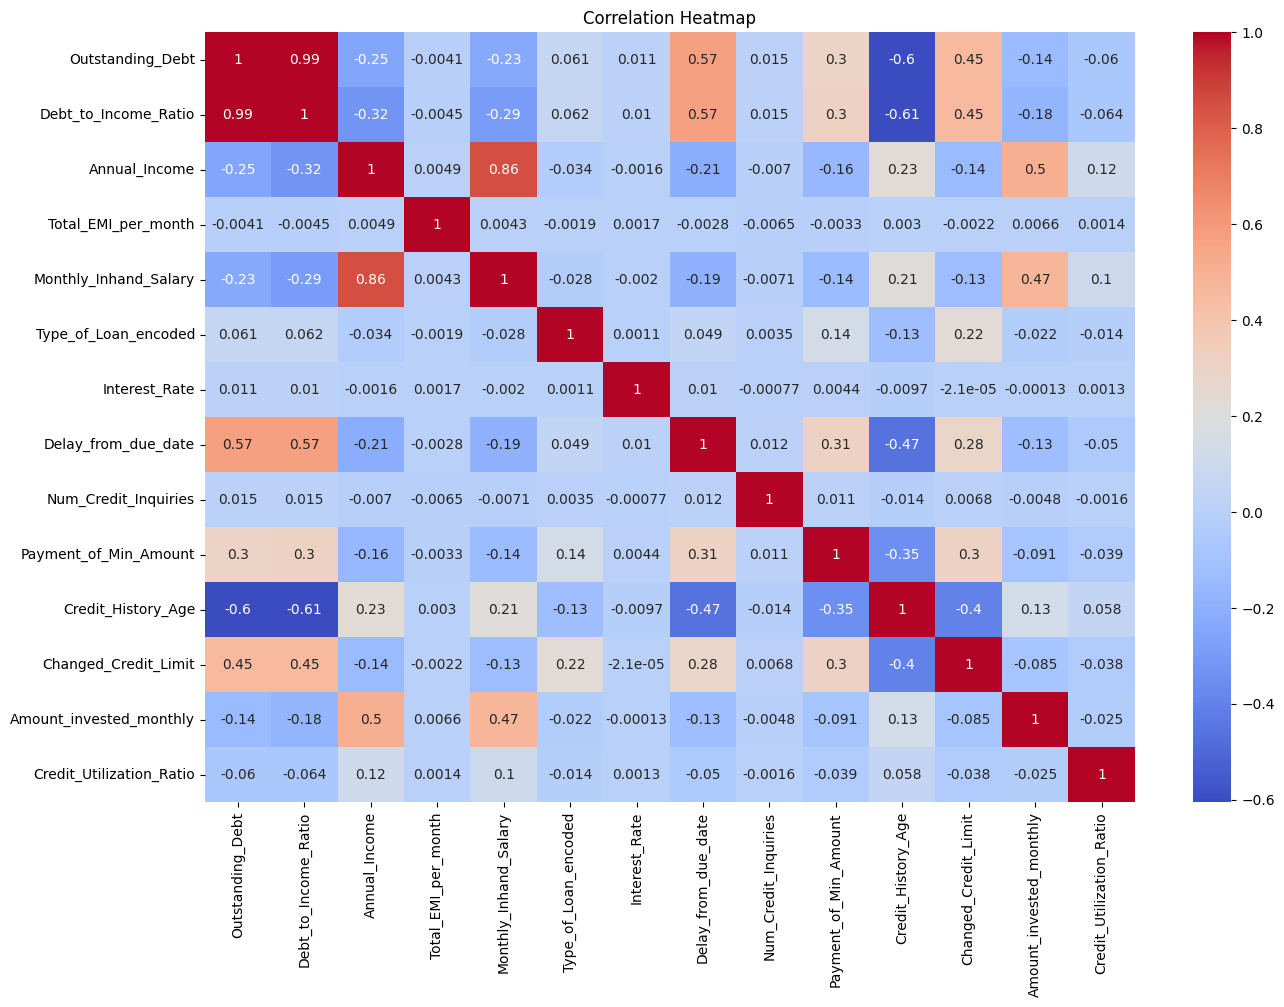

In [49]:
correlation_matrix = X_selected.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


- Outstanding_Debt and Debt_to_Income_Ratio: These two features have a correlation of 0.994566, which is very high, indicating that they provide very similar information.Should remove one of these features to avoid redundancy.

- Annual_Income and Monthly_Inhand_Salary: These two have a correlation of 0.855124, meaning that they are highly correlated. Monthly_Inhand_Salary could be a subset of Annual_Income, so it might be redundant.

- Credit_History_Age and Debt_to_Income_Ratio: These features are negatively correlated (-0.605032), which might indicate some inverse relationship, but they seem to convey different aspects of financial history. You could keep both but be aware of their potential relationship.

- Total_EMI_per_month and Credit_Utilization_Ratio have very low correlations with other features,

In [50]:

# Drop the redundant features
X_selected = X_selected.drop(columns=['Outstanding_Debt', 'Monthly_Inhand_Salary'])

# Display the cleaned dataframe
X_selected.head()


,Debt_to_Income_Ratio,Annual_Income,Total_EMI_per_month,Type_of_Loan_encoded,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Payment_of_Min_Amount,Credit_History_Age,Changed_Credit_Limit,Amount_invested_monthly,Credit_Utilization_Ratio
0,-0.513332,-0.864032,-0.161755,-3.00593,-0.1497,-1.237303,-0.123315,-0.60509,0.490806,0.111582,-0.574728,-1.055422
1,-0.513332,-0.864032,-0.161755,-3.00593,-0.1497,-1.504972,-0.123315,-0.60509,0.007201,0.111582,-0.346504,-0.043923
2,-0.513332,-0.864032,-0.161755,-3.00593,-0.1497,-1.103468,-0.123315,-0.60509,0.522345,-0.628437,0.142782,-0.155907
3,-0.513332,-0.864032,-0.161755,-3.00593,-0.1497,-1.036551,-0.123315,-0.60509,0.532858,0.111582,-0.809765,-1.455349
4,-0.513332,-0.864032,-0.161755,-3.00593,-0.1497,-0.902716,-0.123315,-0.60509,0.543371,-0.184425,-0.683131,-0.968608


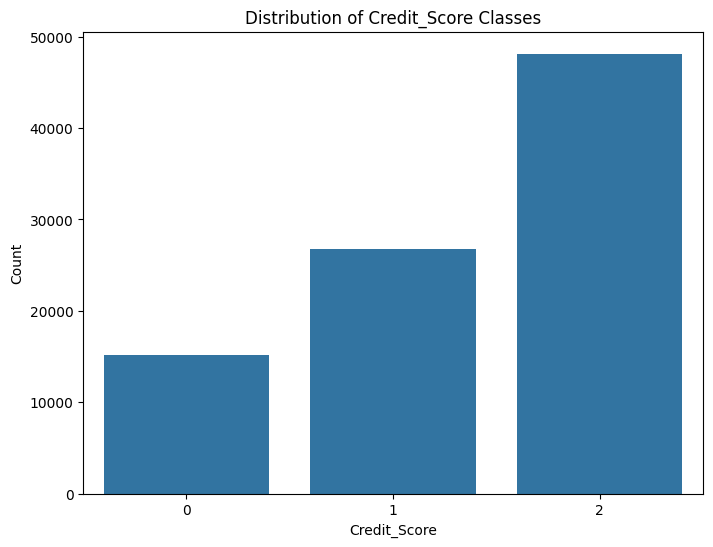

In [51]:
# Visualize the class distribution of the target variable 'Credit_Score'
plt.figure(figsize=(8, 6))
sns.countplot(x='Credit_Score', data=df)
plt.title('Distribution of Credit_Score Classes')
plt.xlabel('Credit_Score')
plt.ylabel('Count')
plt.show()


In [52]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_selected, df['Credit_Score'])


# Model Selection and Evaluation

In [53]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Check the shapes
print(f"Training Data: {X_train.shape}, {y_train.shape}")
print(f"Testing Data: {X_test.shape}, {y_test.shape}")


Training Data: (115545, 12), (115545,)
Testing Data: (28887, 12), (28887,)


In [55]:

# Define models
models = {
    'LogisticRegression': LogisticRegression(random_state=42, multi_class='ovr'),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric="error", objective="multi:softmax", num_class=3)
}

In [56]:
# Function to evaluate models
def evaluate_model(model, model_name):
    print(f"Training {model_name}...")

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Classification Report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    print(f"Confusion Matrix for {model_name}:")
    print(confusion_matrix(y_test, y_pred))

    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name}: {accuracy}")

    # Cross-validation accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation accuracy for {model_name}: {cv_scores.mean()}")

    print("--------------------------------------------------")

In [57]:
# Train and evaluate models
best_model_name = ''
best_accuracy = 0
best_model = None

for model_name, model in models.items():
    evaluate_model(model, model_name)

    # Track best model based on accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = model_name
        best_model = model

print(f"The best model is: {best_model_name} with accuracy: {best_accuracy}")


Training LogisticRegression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.67      0.84      0.75      9608
           1       0.78      0.71      0.74      9657
           2       0.70      0.58      0.63      9622

    accuracy                           0.71     28887
   macro avg       0.72      0.71      0.71     28887
weighted avg       0.72      0.71      0.71     28887

Confusion Matrix for LogisticRegression:
[[8115  438 1055]
 [1447 6827 1383]
 [2579 1461 5582]]
Accuracy for LogisticRegression: 0.7104926091321355


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Cross-validation accuracy for LogisticRegression: 0.7080358301960274
--------------------------------------------------
Training RandomForestClassifier...
Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      9608
           1       0.87      0.87      0.87      9657
           2       0.86      0.78      0.82      9622

    accuracy                           0.86     28887
   macro avg       0.86      0.86      0.86     28887
weighted avg       0.86      0.86      0.86     28887

Confusion Matrix for RandomForestClassifier:
[[9027   77  504]
 [ 503 8401  753]
 [ 913 1223 7486]]
Accuracy for RandomForestClassifier: 0.8624640841901201
Cross-validation accuracy for RandomForestClassifier: 0.854359773248518
--------------------------------------------------
Training KNeighborsClassifier...
Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:36:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for XGBClassifier:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86      9608
           1       0.85      0.81      0.83      9657
           2       0.81      0.76      0.78      9622

    accuracy                           0.82     28887
   macro avg       0.82      0.82      0.82     28887
weighted avg       0.82      0.82      0.82     28887

Confusion Matrix for XGBClassifier:
[[8661  166  781]
 [ 860 7815  982]
 [1123 1166 7333]]
Accuracy for XGBClassifier: 0.8242115830650466


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:36:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:36:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:36:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:36:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:36:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-validation accuracy for XGBClassifier: 0.8243368384612054
--------------------------------------------------
The best model is: RandomForestClassifier with accuracy: 0.8624640841901201


- RandomForestClassifier outperforms all models with an accuracy of 86.25%, offering strong precision and recall, especially for classes 0 and 1.
- XGBoost comes second with 82.42% accuracy, performing well across all classes but with slightly lower recall for class 2.
- Logistic Regression (71.05%) and KNN (78.83%) perform worse, particularly struggling with class 2, but Logistic Regression provides a good baseline.
- Best Model: RandomForestClassifier is the top performer, making it the recommended choice.

# Hyperparameter Tuning

In [59]:
# Parameters for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(100, 501, 100),
    'max_depth': [10, 20, None],
    'min_samples_split': np.arange(2, 11, 2),
    'min_samples_leaf': np.arange(1, 11, 2)
}


# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1,
                                   random_state=42)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation Score: {random_search.best_score_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}
Best Cross-Validation Score: 0.8377861439266088


- The best parameters obtained from the RandomizedSearchCV for the RandomForestClassifier are:
- n_estimators: 500
- max_depth: None
- min_samples_split: 10
- min_samples_leaf: 1

In [60]:
# Use the best model for final evaluation
best_rf_model = random_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy of Best Model: {accuracy}")

Test Accuracy of Best Model: 0.8538096721708727


#### Model Performance:

- The cross-validation score of 83.78% indicates a strong model that generalizes well to unseen data.
- The test accuracy of 85.38% is quite impressive, confirming that the model performs well on unseen data.

In [61]:
# Display classification report and confusion matrix for the best model
print(f"Classification Report for Best Random Forest Model:")
print(classification_report(y_test, y_pred))
print(f"Confusion Matrix for Best Random Forest Model:")
print(confusion_matrix(y_test, y_pred))

Classification Report for Best Random Forest Model:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      9608
           1       0.86      0.86      0.86      9657
           2       0.85      0.77      0.81      9622

    accuracy                           0.85     28887
   macro avg       0.85      0.85      0.85     28887
weighted avg       0.85      0.85      0.85     28887

Confusion Matrix for Best Random Forest Model:
[[8981   92  535]
 [ 578 8273  806]
 [ 998 1214 7410]]


- Class 0 and Class 1 have high precision and recall, which means the model is effective at correctly classifying instances of these classes.

- Class 2 shows slightly lower recall (77%), indicating that the model struggles more with this class, possibly due to data imbalances or inherent difficulty in distinguishing this class.

- The confusion matrix shows that the model is good at classifying class 0 (precision of 0.85 and recall of 0.93) but tends to misclassify class 2 (with some confusion between class 2 and class 1).

- The model performs well in reducing false positives and false negatives for most classes.

In [62]:
import joblib

# Save the best model
joblib.dump(best_rf_model, 'best_random_forest_model.joblib')



['best_random_forest_model.joblib']

In [66]:
index_value = 1000

# Fetch feature values for the given index
feature_values = X_balanced.loc[index_value]

# Iterate over the feature values and print them using .items()
for column_name, value in feature_values.items():
    print(f"{column_name}: {value}")


Debt_to_Income_Ratio: -0.5501439677714827
Annual_Income: -0.5497483600708071
Total_EMI_per_month: -0.16607934167269534
Type_of_Loan_encoded: 0.02144244046801475
Interest_Rate: -0.14328192626026884
Delay_from_due_date: 0.3017953385318061
Num_Credit_Inquiries: -0.13374723462490587
Payment_of_Min_Amount: -0.6050901057934851
Credit_History_Age: 0.41721374020103125
Changed_Credit_Limit: -1.4572573759725498
Amount_invested_monthly: -0.8047427250674918
Credit_Utilization_Ratio: -0.44519835492606896


In [71]:
# Make a prediction using new data
input_features =[
{
'Debt_to_Income_Ratio': -0.5501439677714827,
'Annual_Income': -0.5497483600708071,
'Total_EMI_per_month': -0.16607934167269534,
'Type_of_Loan_encoded': 0.02144244046801475,
'Interest_Rate': -0.14328192626026884,
'Delay_from_due_date': 0.3017953385318061,
'Num_Credit_Inquiries': -0.13374723462490587,
'Payment_of_Min_Amount': -0.6050901057934851,
'Credit_History_Age': 0.41721374020103125,
'Changed_Credit_Limit': -1.4572573759725498,
'Amount_invested_monthly': -0.8047427250674918,
'Credit_Utilization_Ratio': 0.5
}
]

# define input data
input_data = pd.DataFrame(input_features)

# Pass the DataFrame directly to the model's predict method
predictions = best_rf_model.predict(input_data)

# Print the predicted market value
print(f"Predicted Credit Score is {predictions}")


Predicted Credit Score is [0]


# Done